# UKKO - Transformer model for tabular longitudonal data 

Author: Eric Fey (eric.fey@hus.fi)
First version: 2025-03-01

Usage:
1. Install hatchling 
  ```bash
  pip install hatchling
  ```
2. Install ukko package in development (editable) mode:
  ```bash
  pip install -e .
  ```
3. Go :smiley:

In [1]:
!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///users/ericfey1/github/ukko
  Installing build dependencies ..done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... one
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ukko (pyproject.toml) ... done
  Created wheel for ukko: filename=ukko-0.1.0-py3-none-any.whl size=1088 sha256=ecf792c0a5f0ba587d1f251fb19a246789501725ec70f3b0c387eb4910a892fa
  Stored in directory: /tmp/ericfey1/27113521/pip-ephem-wheel-cache-why9m30y/wheels/d6/05/1b/87b6398b4c9fcb6c3490d41e36b033368cd35528f738f0e67e
Successfully built ukko
  Attempting uninstall: ukko
    Found existing installation: ukko 0.1.0
    Uninstalling ukko-0.1.0:
      Successfully uninstalled ukko-0.1.0

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --up

In [4]:
# attention model with residual connectoin
import torch
import torch.nn as nn
import math
import ukko 
import importlib
import ukko.core
import ukko.data

importlib.reload(ukko.core)
importlib.reload(ukko.data)
importlib.reload(ukko.test)


<module 'ukko.test' from '/users/ericfey1/github/ukko/src/ukko/test.py'>

In [8]:
# Test ukko installatin and model
%run ./tests/tests_core.py
model = test_model()

Input shape: torch.Size([2, 3, 5])
Output shape: torch.Size([2, 3])
Feature attention weights shape: torch.Size([10, 5, 3, 3])
Time attention weights shape: torch.Size([6, 5, 5, 5])


## Test data sine wave

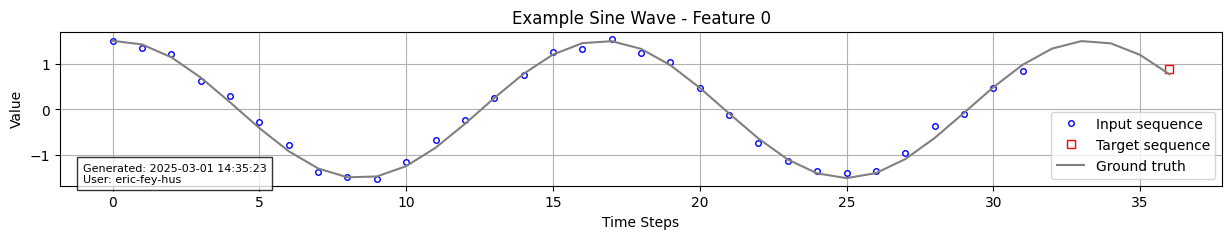

In [25]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
import ukko

def create_data_loaders(batch_size=32, n_samples=1000, n_features=15,
                       sequence_length=100, prediction_length=5):
    """Create train, validation, and test data loaders"""

    # Create datasets
    train_dataset = ukko.data.SineWaveDataset(n_samples, n_features, sequence_length, prediction_length)
    val_dataset = ukko.data.SineWaveDataset(n_samples//5, n_features, sequence_length, prediction_length, seed=43)
    test_dataset = ukko.data.SineWaveDataset(n_samples//5, n_features, sequence_length, prediction_length, seed=44)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def test_model_with_sine_data():
    # Parameters
    batch_size = 32
    n_samples = 1000
    n_features = 3
    sequence_length = 32
    prediction_length = 5

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        batch_size=batch_size,
        n_samples=n_samples,
        n_features=n_features,
        sequence_length=sequence_length,
        prediction_length=prediction_length
    )

    # Initialize model
    model = ukko.core.DualAttentionRegressor(
        n_features=n_features,
        time_steps=sequence_length,
        d_model=128,
        n_heads=8,
        dropout=0.1
    )
    #model = []


    # Plot example
    dataset = ukko.data.SineWaveDataset(n_samples, n_features, sequence_length, prediction_length)
    ukko.data.plot_example_dataset(dataset, sample_idx=1)

    return model, train_loader, val_loader, test_loader

#if __name__ == "__main__":
model, train_loader, val_loader, test_loader = test_model_with_sine_data()

Trainset: 1000
Trainset: (1000, 10, 32, 5)
Valset:   (200, 10, 32, 5)
Testset:  (200, 10, 32, 5)


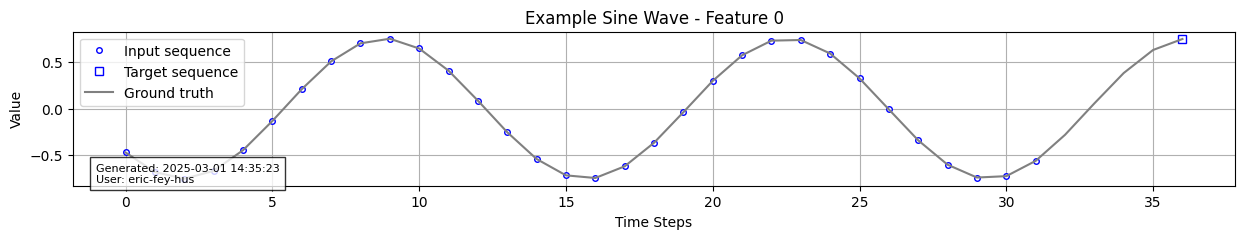

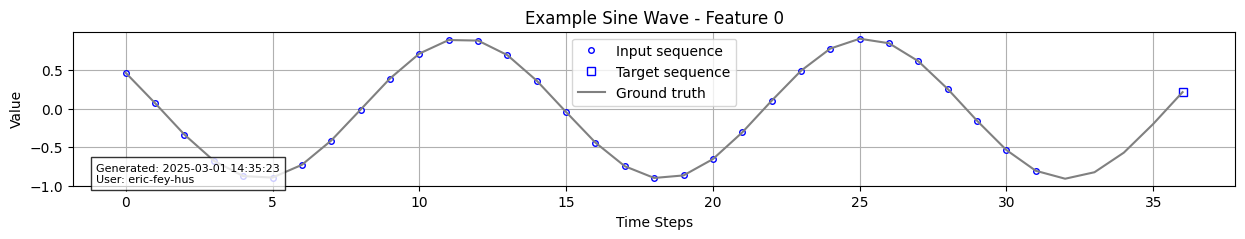

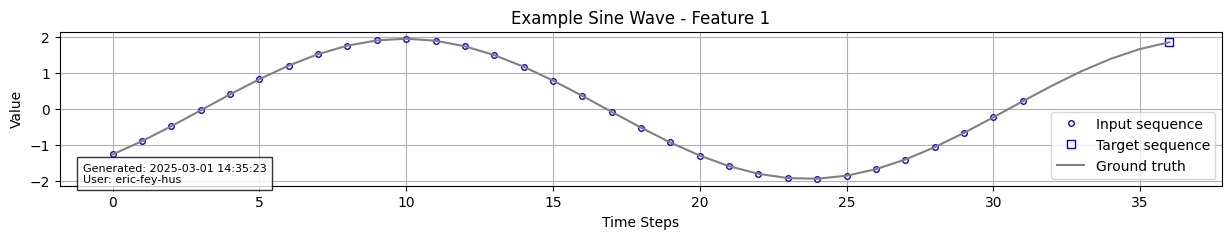

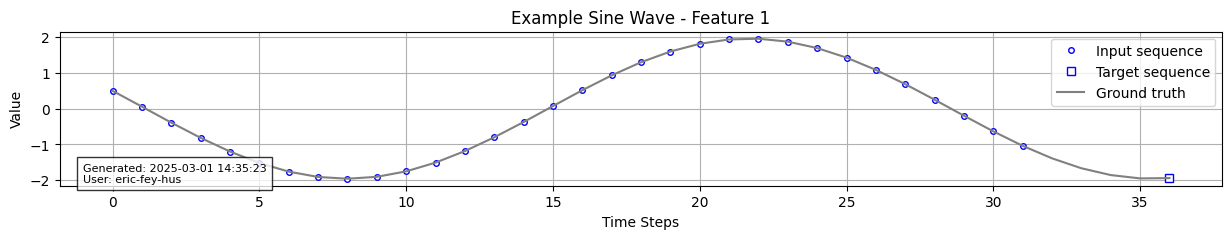

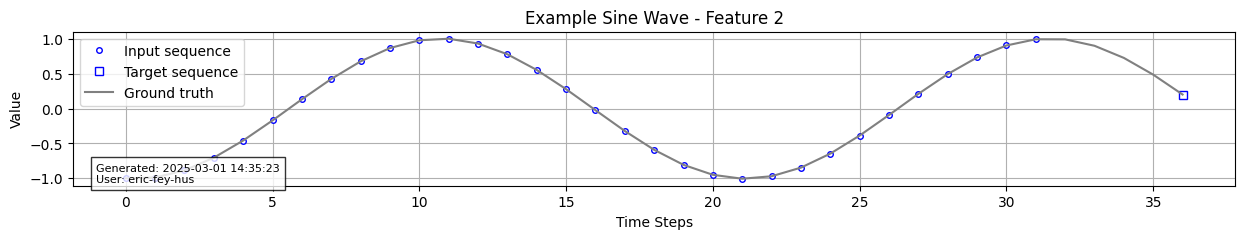

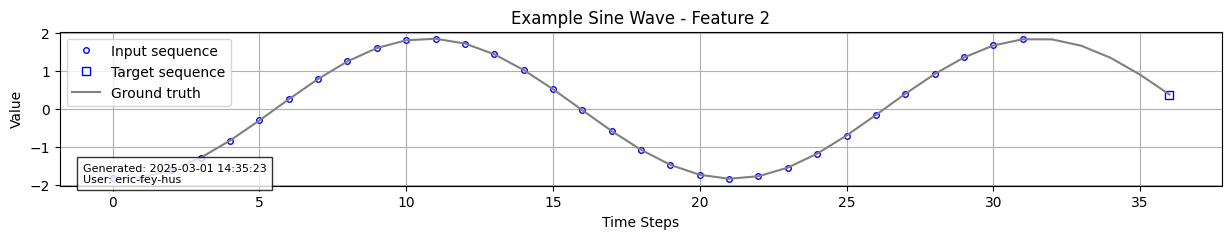

In [103]:
importlib.reload(ukko.data)

# Parameters
batch_size = 32
n_samples = 1400
n_features = 10
sequence_length = 32
prediction_length = 5

# Create dataset:
dataset = ukko.data.SineWaveDataset(n_samples, n_features, sequence_length, prediction_length,
                                   base_freq=0.05, noise_level=0.0)
ukko.data.plot_example_dataset(dataset, sample_idx=0, feature_idx=0)
ukko.data.plot_example_dataset(dataset, sample_idx=1, feature_idx=0)
ukko.data.plot_example_dataset(dataset, sample_idx=0, feature_idx=1)
ukko.data.plot_example_dataset(dataset, sample_idx=1, feature_idx=1)
ukko.data.plot_example_dataset(dataset, sample_idx=0, feature_idx=2)
ukko.data.plot_example_dataset(dataset, sample_idx=1, feature_idx=2)

trainset = dataset.Subset(range(0,1000))
valset = dataset.Subset(range(1000,1200))
testset = dataset.Subset(range(1200,1400))

print(f"Trainset: {trainset.__len__()}")
print(f"Trainset: {trainset.getdim()}")
print(f"Valset:   {valset.getdim()}")
print(f"Testset:  {testset.getdim()}")

# Create data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size)
test_loader = DataLoader(testset, batch_size=batch_size)

# Initialize model
#model = ukko.core.DualAttentionRegressor(
model = ukko.core.DualAttentionModelOld(
    n_features=n_features,
    time_steps=sequence_length,
    d_model=128,
    n_heads=16,
    dropout=0.1
)


In [49]:
from itertools import islice
for x, y in islice(val_loader, 2):
  print(x.shape)
  print(y.shape)

torch.Size([32, 3, 32])
torch.Size([32, 3])
torch.Size([32, 3, 32])
torch.Size([32, 3])


In [105]:
def train_sine_model(model, train_loader, val_loader, epochs=50, lr=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output, _, _ = model(x)
            #loss = criterion(output, y[:, :, 0])  # Compare with first time step of prediction
            loss = criterion(output, y)  # y is only one timepoint 5 or 4 steps ahead

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output, _, _ = model(x)
                #val_loss += criterion(output, y[:, :, 0]).item()
                val_loss += criterion(output, y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_sine_model.pt')

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model, train_loader, val_loader, test_loader = test_model_with_sine_data()
train_sine_model(model, train_loader, val_loader, epochs = 50, device = device)

Epoch 1/50, Train Loss: 0.2638, Val Loss: 0.0259
Epoch 2/50, Train Loss: 0.0108, Val Loss: 0.0056
Epoch 3/50, Train Loss: 0.0040, Val Loss: 0.0058
Epoch 4/50, Train Loss: 0.0032, Val Loss: 0.0057
Epoch 5/50, Train Loss: 0.0029, Val Loss: 0.0048
Epoch 6/50, Train Loss: 0.0027, Val Loss: 0.0046
Epoch 7/50, Train Loss: 0.0025, Val Loss: 0.0047
Epoch 8/50, Train Loss: 0.0026, Val Loss: 0.0054
Epoch 9/50, Train Loss: 0.0023, Val Loss: 0.0057
Epoch 10/50, Train Loss: 0.0023, Val Loss: 0.0054
Epoch 11/50, Train Loss: 0.0021, Val Loss: 0.0042
Epoch 12/50, Train Loss: 0.0020, Val Loss: 0.0040
Epoch 13/50, Train Loss: 0.0020, Val Loss: 0.0039
Epoch 14/50, Train Loss: 0.0019, Val Loss: 0.0030
Epoch 15/50, Train Loss: 0.0019, Val Loss: 0.0037
Epoch 16/50, Train Loss: 0.0020, Val Loss: 0.0045
Epoch 17/50, Train Loss: 0.0018, Val Loss: 0.0040
Epoch 18/50, Train Loss: 0.0018, Val Loss: 0.0049
Epoch 19/50, Train Loss: 0.0018, Val Loss: 0.0040
Epoch 20/50, Train Loss: 0.0018, Val Loss: 0.0039
Epoch 21/

/tmp/ericfey1/27114675/ipykernel_540870/2913784709.py:171: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_sine_model.pt'))
/tmp/ericfey

Loaded best model weights successfully!
Test Set Metrics:
Average MSE: 0.0016
Average MAE: 0.0362
RMSE: 0.0395
[36]
0.118516095
[36]
0.92063403
[36]
-0.74575514
[36]
0.032972842
[36]
-2.0130904
[36]
0.05077488
[36]
0.1412094
[36]
0.1667195
[36]
0.19565645
Data: (32, 10)
Predictions: (32, 10)


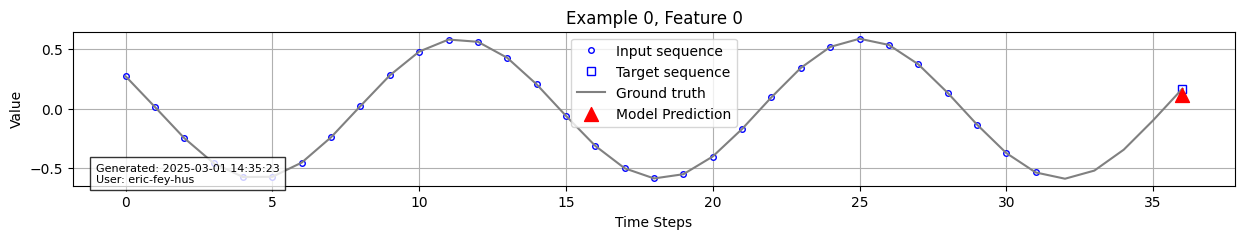

<Figure size 1500x1000 with 0 Axes>

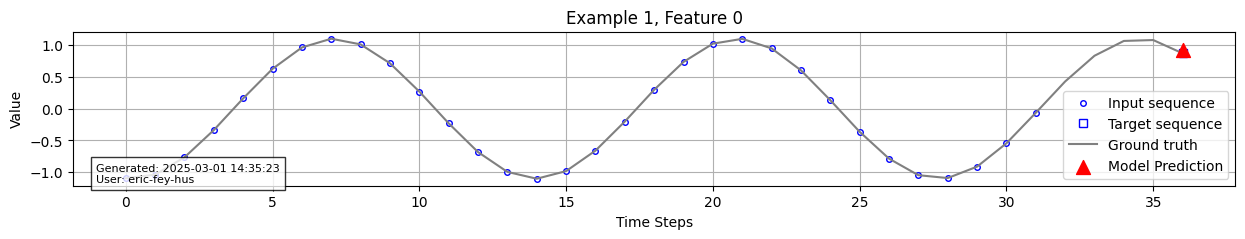

<Figure size 1500x1000 with 0 Axes>

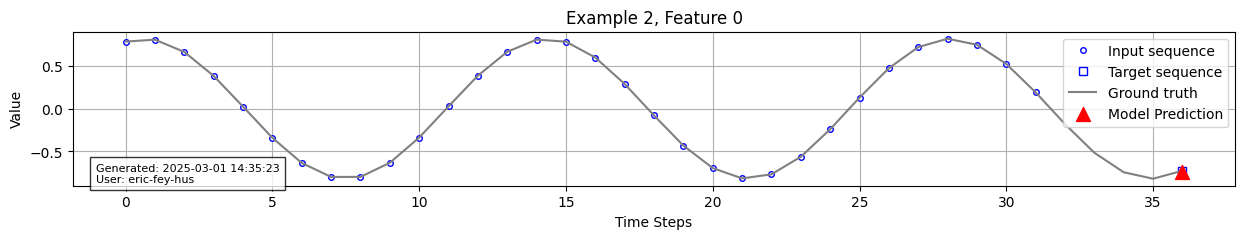

<Figure size 1500x1000 with 0 Axes>

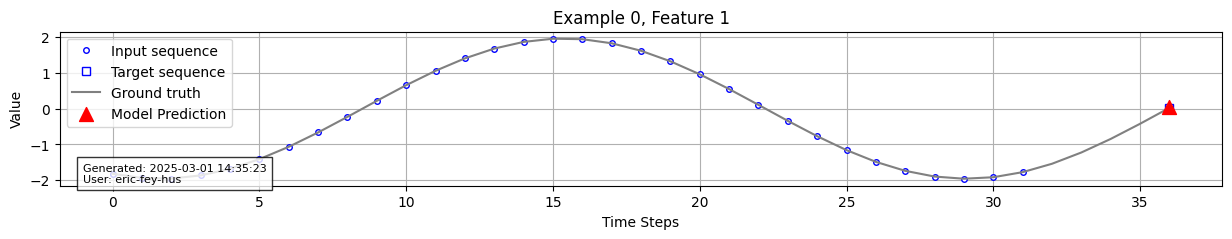

<Figure size 1500x1000 with 0 Axes>

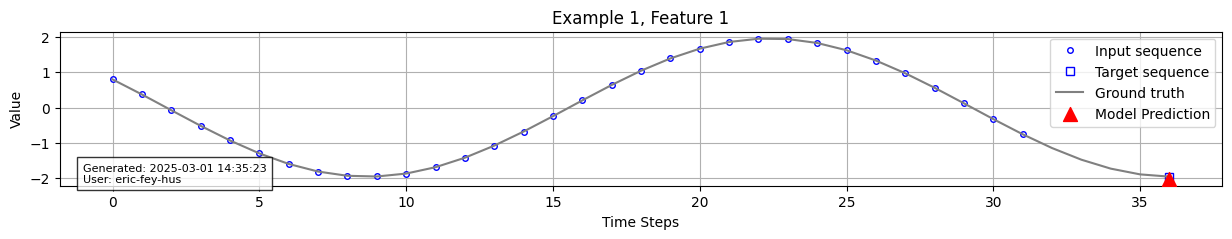

<Figure size 1500x1000 with 0 Axes>

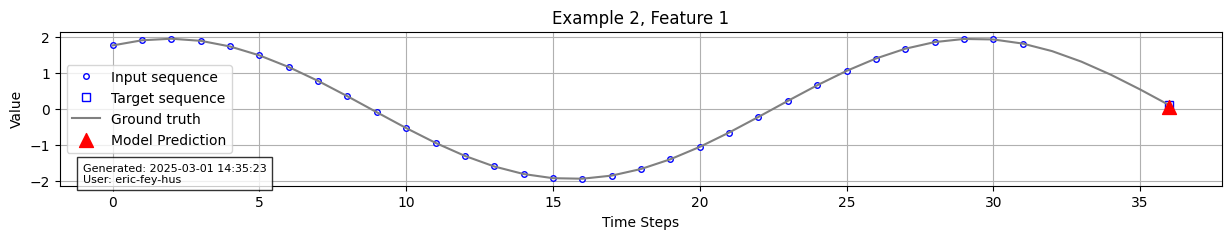

<Figure size 1500x1000 with 0 Axes>

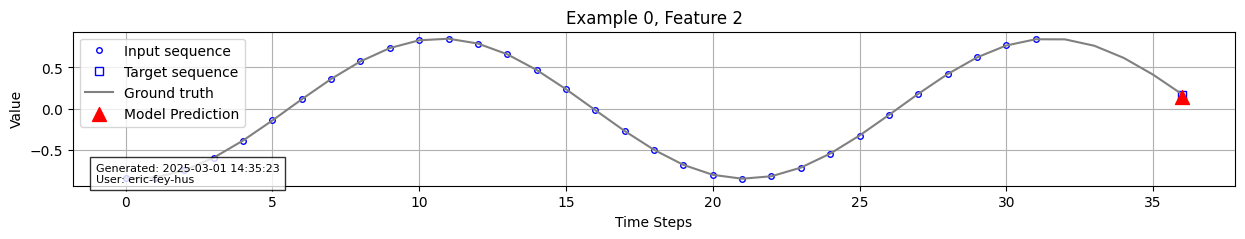

<Figure size 1500x1000 with 0 Axes>

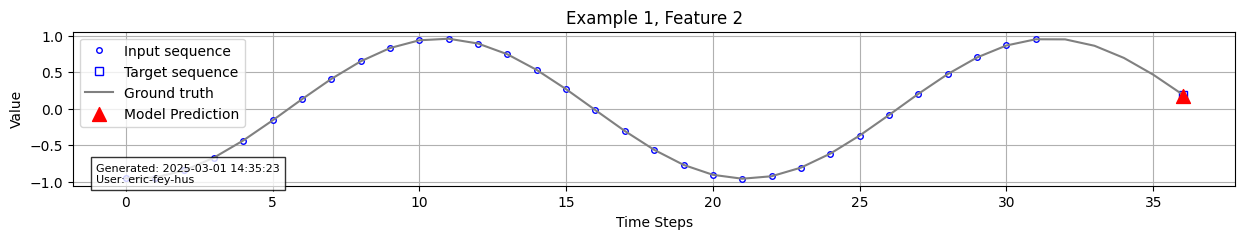

<Figure size 1500x1000 with 0 Axes>

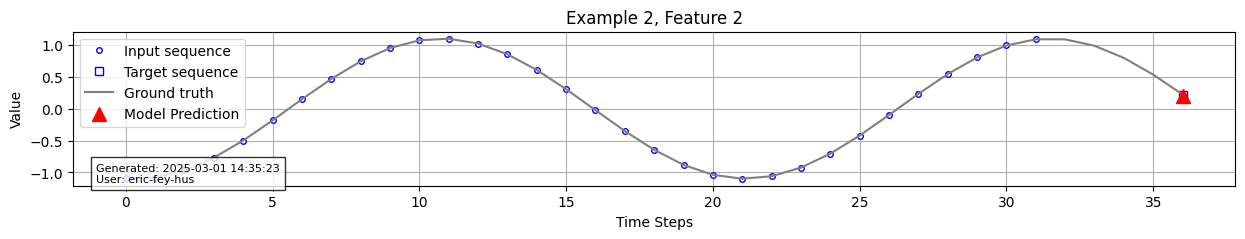

<Figure size 1500x1000 with 0 Axes>

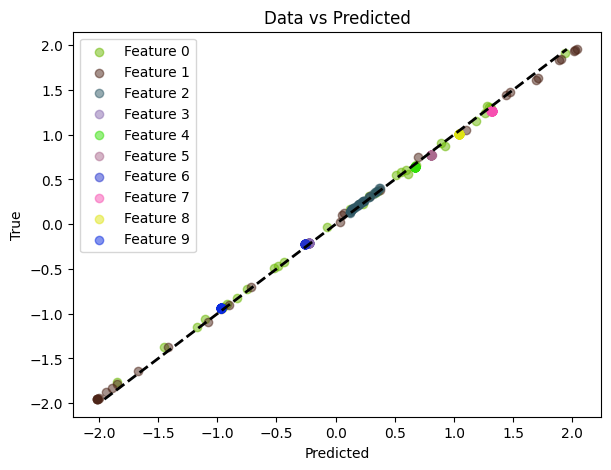

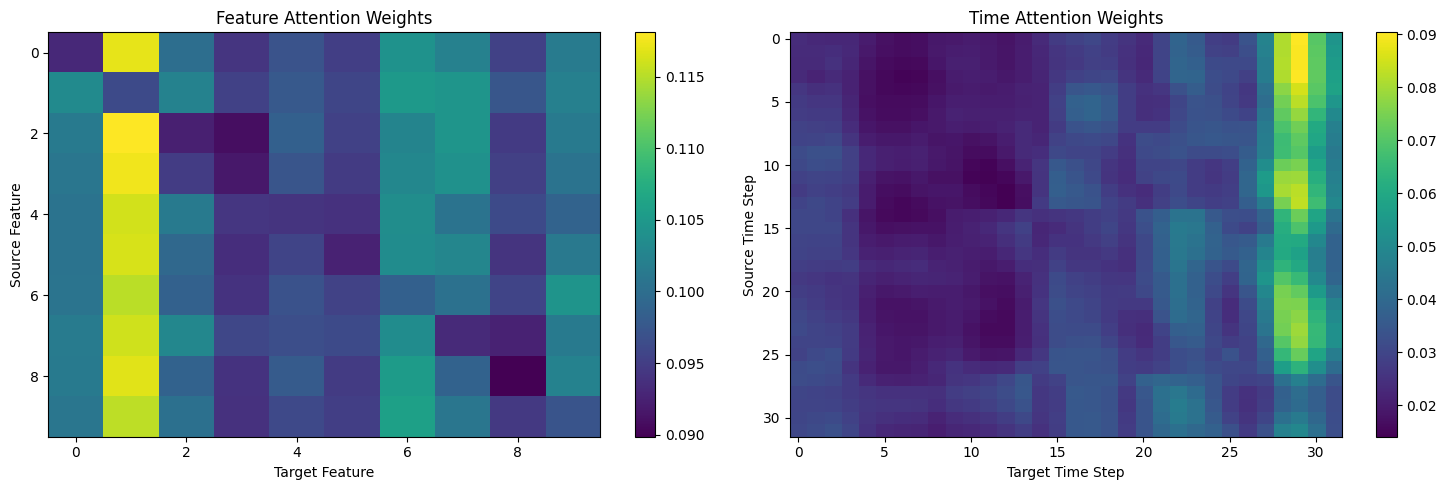

In [106]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

importlib.reload(ukko.data)

def visualize_predictions(model, test_loader, device='cuda', num_examples=3):
    model.eval()

    # Get some test examples
    x, y = next(iter(test_loader))
    x, y = x.to(device), y.to(device)

    # Get predictions
    with torch.no_grad():
        predictions, feat_attn, time_attn = model(x)
        predictions = predictions.cpu().numpy()
        x = x.cpu().numpy()
        y = y.cpu().numpy()

    # Plot 3 different features
    for i, feature_idx in enumerate([0,1,2]):#([0, 7, 14]):  # Beginning, middle, and end features
        #plt.figure(figsize=(15, 10))

        # Plot multiple features for a few examples
        for example_idx in range(min(num_examples, x.shape[0])):
            #plt.subplot(3, 1, example_idx+1)

            # # Plot input sequence
            # time_input = np.arange(x.shape[2])
            # plt.plot(time_input, x[example_idx, feature_idx],
            #         label='Input Sequence', color='blue')

            # # Plot true continuation
            # #time_target = np.arange(x.shape[2], x.shape[2] + y.shape[2])
            # time_target = [x.shape[2] + 5 - 1]
            # plt.plot(time_target, y[example_idx, feature_idx], "x-",
            #         label='True Continuation', color='green')

            fig = ukko.data.plot_example_dataset(testset, example_idx, feature_idx)
            ax = fig.axes[0]
            
            # Time of prediction 
            time_input = np.arange(x.shape[2])
            #time_target = np.arange(x.shape[2], x.shape[2] + y.shape[2])
            time_target = [x.shape[2] + prediction_length - 1]
            
            # Plot prediction
            print(time_target)
            print(predictions[example_idx, feature_idx])
            plt.figure(figsize=(15, 10))
            ax.scatter(time_target[0], predictions[example_idx, feature_idx].item(),
                       marker = '^', label='Model Prediction', color='red', s=100, 
                      zorder=5)
            #ax.plot(time_target[0], predictions[example_idx, feature_idx],
            #           marker = '^', label='Model Prediction', color='red', markersize=5)

            ax.set_title(f'Example {example_idx}, Feature {feature_idx}')
            ax.legend()
            ax.grid(True)
            #plt.pause(0.1)
            #fig.canvas.draw()
            #fig.show()

        #fig.tight_layout()
        #fig.canvas.draw()

    # Plot data vs predicted & groundtruth vs predicted
    plt.figure(figsize=(15, 5))
    # data vs predicted
    plt.subplot(1, 2, 1)
    print(f"Data: {y.shape}")
    print(f"Predictions: {predictions.shape}")
    np.random.seed(1)
    for col in range(y.shape[1]):
      plt.scatter(predictions[:,col], y[:,col],
                  c=np.random.rand(3,), label=f'Feature {col}', alpha=0.5)
    # Add perfect line
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Data vs Predicted')
    plt.legend()

    # Visualize attention weights
    plt.figure(figsize=(15, 5))

    # Feature attention weights
    plt.subplot(1, 2, 1)
    feat_attn_avg = feat_attn.mean(dim=(0, 1)).cpu().numpy()
    plt.imshow(feat_attn_avg, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Feature Attention Weights')
    plt.xlabel('Target Feature')
    plt.ylabel('Source Feature')

    # Time attention weights
    plt.subplot(1, 2, 2)
    time_attn_avg = time_attn.mean(dim=(0, 1)).cpu().numpy()
    plt.imshow(time_attn_avg, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Time Attention Weights')
    plt.xlabel('Target Time Step')
    plt.ylabel('Source Time Step')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    criterion = torch.nn.MSELoss()
    total_mse = 0
    total_mae = 0
    num_batches = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            predictions, _, _ = model(x)

            # Calculate MSE and MAE
            #mse = criterion(predictions, y[:, :, 0])
            #mae = torch.abs(predictions - y[:, :, 0]).mean()
            mse = criterion(predictions, y)
            mae = torch.abs(predictions - y).mean()

            total_mse += mse.item()
            total_mae += mae.item()
            num_batches += 1

    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches

    print(f"Test Set Metrics:")
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average MAE: {avg_mae:.4f}")
    print(f"RMSE: {np.sqrt(avg_mse):.4f}")

    return avg_mse, avg_mae

def main():
    # Parameters
    # batch_size = 32
    # n_samples = 1000
    # n_features = 3
    # sequence_length = 32
    # prediction_length = 5

    # Create data loaders
    # train_loader, val_loader, test_loader = create_data_loaders(
    #     batch_size=batch_size,
    #     n_samples=n_samples,
    #     n_features=n_features,
    #     sequence_length=sequence_length,
    #     prediction_length=prediction_length
    # )

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = ukko.core.DualAttentionModel(
    #     n_features=n_features,
    #     time_steps=sequence_length,
    #     d_model=128,
    #     n_heads=8,
    #     dropout=0.1
    # ).to(device)

    # Load best model weights
    try:
        model.load_state_dict(torch.load('best_sine_model.pt'))
        print("Loaded best model weights successfully!")
    except:
        print("No saved model found. Please train the model first.")
        return

    # Evaluate model
    mse, mae = evaluate_model(model, test_loader, device)

    # Visualize results
    visualize_predictions(model, test_loader, device)

    # Save a timestamp of when these results were generated
    timestamp = "2025-03-01 10:01:16"  # Using the provided timestamp
    user = "eric-fey-hus"

    # Save results to a file
    with open('model_results.txt', 'w') as f:
        f.write(f"Results generated on: {timestamp}\n")
        f.write(f"Generated by user: {user}\n")
        f.write(f"Model Performance Metrics:\n")
        f.write(f"MSE: {mse:.4f}\n")
        f.write(f"MAE: {mae:.4f}\n")
        f.write(f"RMSE: {np.sqrt(mse):.4f}\n")

#if __name__ == "__main__":
main()

# Classifier

Starting training...
  Batch 0 - Data shape: torch.Size([32, 10, 50]), Target shape: torch.Size([32, 10])
Epoch 1/3, Loss: 1.1732
  Batch 0 - Data shape: torch.Size([32, 10, 50]), Target shape: torch.Size([32, 10])
Epoch 2/3, Loss: 1.1081
  Batch 0 - Data shape: torch.Size([32, 10, 50]), Target shape: torch.Size([32, 10])
Epoch 3/3, Loss: 1.1084
Training complete!


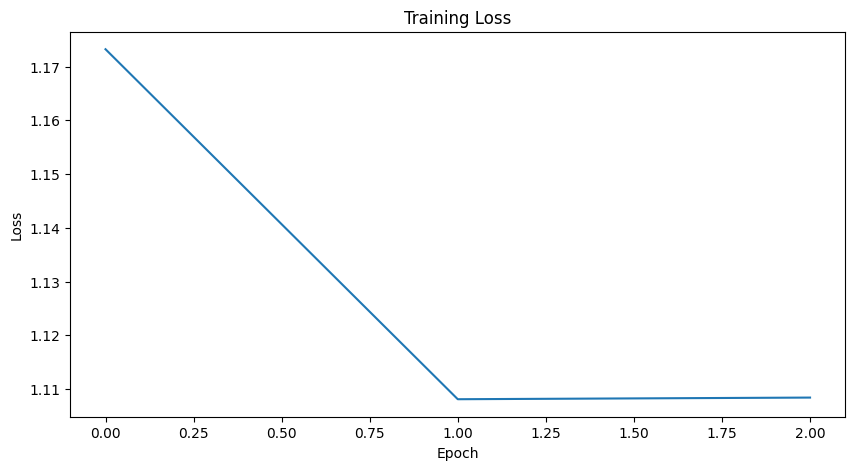

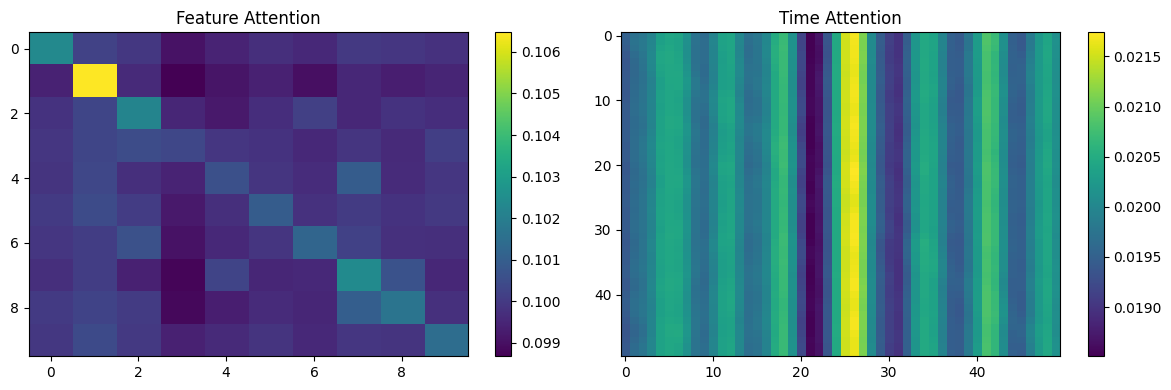

In [16]:
# First reload modules to ensure latest changes
import importlib
import ukko.core
import ukko.data
importlib.reload(ukko.core)
importlib.reload(ukko.data)

# Import test function 
from ukko.core import DualAttentionClassifier, visualize_predictions
from ukko.data import SineWaveDataset

# Run the test
#from tests.test_dual_attention_classifier import test_dual_attention_classifier
#test_dual_attention_classifier()

%run ./tests/test_dual_attention_classifier.py
model, train_losses, plt1, plt2 = test_dual_attention_classifier(n_epochs = 3)